Training Accuracy: 0.8475120385232745
Test Accuracy: 0.8111111111111111


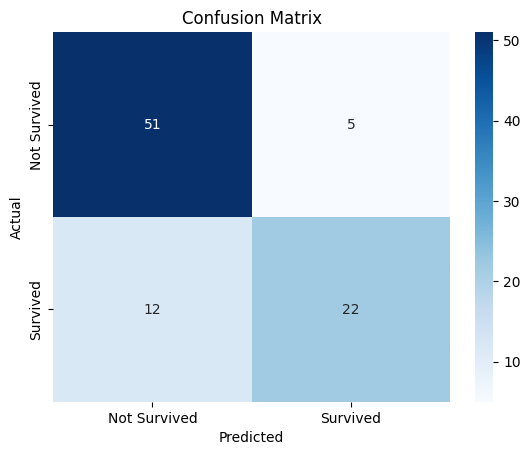

              precision    recall  f1-score   support

           0       0.81      0.91      0.86        56
           1       0.81      0.65      0.72        34

    accuracy                           0.81        90
   macro avg       0.81      0.78      0.79        90
weighted avg       0.81      0.81      0.81        90



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter

class Node:
  def __init__(self,feature=None,threshold=None,left=None,right=None,*,value=None):
    self.feature=feature
    self.threshold=threshold
    self.left=left
    self.right=right
    self.value=value
  def is_leaf_node(self):
    return self.value is not None

class DecisionTree:
  def __init__(self,min_samples_split=2,max_depth=100,n_features=None):
    self.min_samples_split=min_samples_split
    self.max_depth=max_depth
    self.n_features=n_features
    self.root=None

  def fit(self,X,y):
    self.n_features=X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
    self.root=self._grow_tree(X,y)

  def _grow_tree(self,X,y,depth=0):
    n_samples,n_feats=X.shape
    n_labels=len(np.unique(y))
    #check stopping criteria
    if(depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
      leaf_value=self._most_common_label(y)
      return Node(value=leaf_value)

    feat_idxs=np.random.choice(n_feats,self.n_features,replace=False)
    best_feature,best_thresh=self._best_split(X,y,feat_idxs)
    left_idxs,right_idxs=self._split(X[:,best_feature],best_thresh)
    left=self._grow_tree(X[left_idxs,:],y[left_idxs],depth+1)
    right=self._grow_tree(X[right_idxs,:],y[right_idxs],depth+1)
    return Node(best_feature,best_thresh,left,right)


  def _best_split(self,X,y,feat_idxs):
    best_gain=-1
    split_idx, split_threshold=None,None

    for feat_idx in feat_idxs:
      X_column=X[:,feat_idx]
      thresholds=np.unique(X_column)
      for thr in thresholds:
        gain=self._information_gain(y,X_column,thr)
        if gain>best_gain:
          best_gain=gain
          split_idx=feat_idx
          split_threshold=thr
    return split_idx, split_threshold

  def _most_common_label(self,y):
    counter=Counter(y)
    value=counter.most_common(1)[0][0]
    return value

  def _information_gain(self,y,X_column,thr):
    #parent entropy
    parent_entropy=self._entropy(y)
    #children entropy
    left_idxs,right_idxs=self._split(X_column,thr)

    if len(left_idxs)==0 or len(right_idxs)==0:
      return 0
    #weight avg entropy
    n=len(y)
    n_l,n_r=len(left_idxs),len(right_idxs)
    e_l,e_r=self._entropy(y[left_idxs]),self._entropy(y[right_idxs])
    child_entropy=(n_l/n)*e_l+(n_r/n)*e_r
    information_gain=parent_entropy-child_entropy

    return information_gain

  def _entropy(self,y):
    hist=np.bincount(y)
    #histogram
    ps=hist/len(y)
    return  -np.sum([p*np.log(p) for p in ps if p>0 ])

  def _split(self,X_column,split_thresh):
    left_idxs=np.argwhere(X_column<=split_thresh).flatten()
    #gives all indices items in array form lessthan threshold
    right_idxs=np.argwhere(X_column>split_thresh).flatten()
    return left_idxs,right_idxs

  def predict(self,X):
    return np.array([self._traverse_tree(x,self.root) for x in X])

  def _traverse_tree(self,x,node):
    if node.is_leaf_node():
      return node.value

    if x[node.feature] <= node.threshold:
      return self._traverse_tree(x,node.left)
    else:
      return self._traverse_tree(x,node.right)


# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df.drop(columns=['Cabin'], inplace=True)
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
X = df.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId'])
y = df['Survived']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

tree = DecisionTree(min_samples_split=2, max_depth=5)
tree.fit(X_train.values, y_train.values)

train_preds = tree.predict(X_train.values)
test_preds = tree.predict(X_test.values)
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# (Precision, Recall, F1-score)
class_report = classification_report(y_test, test_preds)
print(class_report)
